# Toyota GR Racing Data Visualization & Analysis

This notebook provides comprehensive visualizations and correlation analysis for Toyota GR racing data from COTA Race 1.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Data Loading

In [12]:
# Load datasets
driver_stats = pd.read_csv('../datasets_clean/driver_session_stats.csv')
telemetry_summary = pd.read_csv('../datasets_clean/per_lap_telemetry_summary.csv')
weather = pd.read_csv('../datasets/circuit-of-the-americas/COTA/Race 1/26_Weather_Race 1_Anonymized.csv', sep=';')

# Load individual driver data
import glob
driver_files = glob.glob('../datasets_clean/driver_*.csv')
all_laps = []
for file in driver_files:
    df = pd.read_csv(file)
    all_laps.append(df)
lap_data = pd.concat(all_laps, ignore_index=True)

print(f"Driver stats: {driver_stats.shape}")
print(f"Telemetry summary: {telemetry_summary.shape}")
print(f"Weather data: {weather.shape}")
print(f"Lap data: {lap_data.shape}")

Driver stats: (29, 9)
Telemetry summary: (346, 6)
Weather data: (44, 9)
Lap data: (354, 49)


## 1. Performance Distribution Analysis

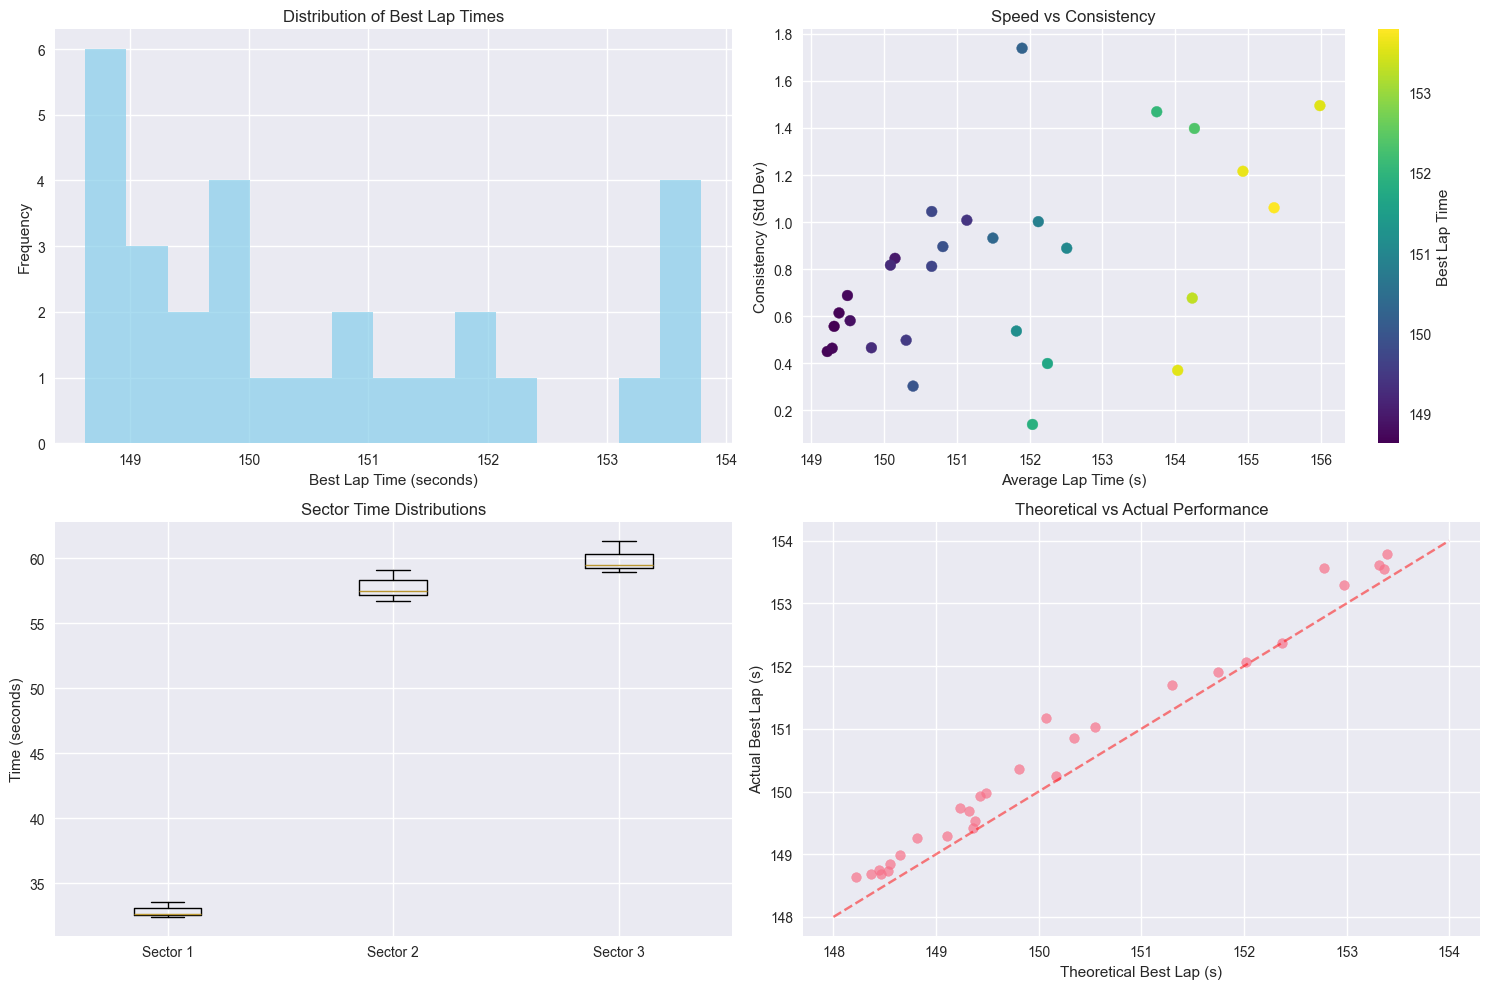

In [13]:
# Lap time distribution by driver
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Best lap times distribution
axes[0,0].hist(driver_stats['BestLap(s)'], bins=15, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of Best Lap Times')
axes[0,0].set_xlabel('Best Lap Time (seconds)')
axes[0,0].set_ylabel('Frequency')

# Average lap vs consistency (std dev)
scatter = axes[0,1].scatter(driver_stats['AvgLap(s)'], driver_stats['StdDev(s)'], 
                           c=driver_stats['BestLap(s)'], cmap='viridis', s=60)
axes[0,1].set_xlabel('Average Lap Time (s)')
axes[0,1].set_ylabel('Consistency (Std Dev)')
axes[0,1].set_title('Speed vs Consistency')
plt.colorbar(scatter, ax=axes[0,1], label='Best Lap Time')

# Sector performance comparison
sector_data = driver_stats[['S1Best', 'S2Best', 'S3Best']].values
axes[1,0].boxplot(sector_data, labels=['Sector 1', 'Sector 2', 'Sector 3'])
axes[1,0].set_title('Sector Time Distributions')
axes[1,0].set_ylabel('Time (seconds)')

# Theoretical vs actual best lap
axes[1,1].scatter(driver_stats['TheoreticalBest(s)'], driver_stats['BestLap(s)'], alpha=0.7)
axes[1,1].plot([148, 154], [148, 154], 'r--', alpha=0.5)
axes[1,1].set_xlabel('Theoretical Best Lap (s)')
axes[1,1].set_ylabel('Actual Best Lap (s)')
axes[1,1].set_title('Theoretical vs Actual Performance')

plt.tight_layout()
plt.show()

## 2. Telemetry Correlation Analysis

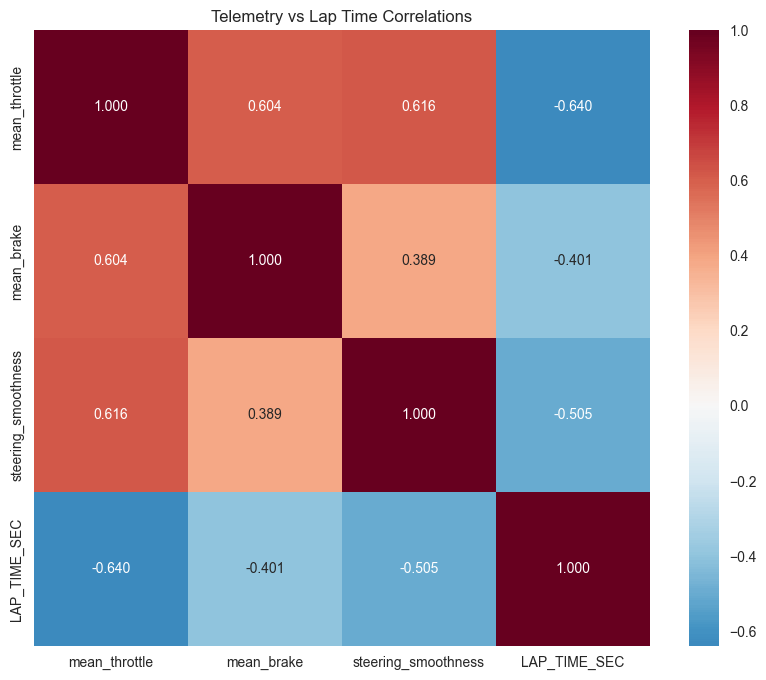

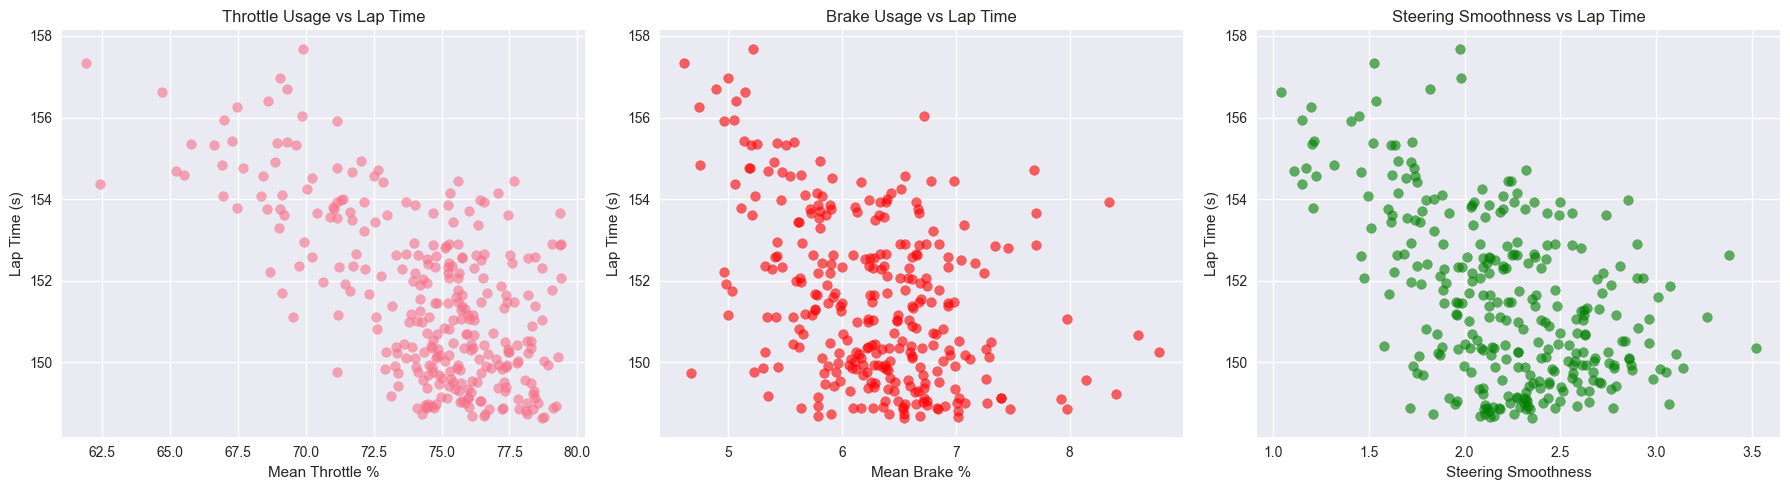

In [14]:
# Merge telemetry with lap times
telemetry_with_times = telemetry_summary.merge(
    lap_data[['NUMBER', 'LAP_NUMBER', 'LAP_TIME_SEC']], 
    left_on=['NUMBER', 'lap'], 
    right_on=['NUMBER', 'LAP_NUMBER'], 
    how='inner'
)

# Correlation heatmap
corr_cols = ['mean_throttle', 'mean_brake', 'steering_smoothness', 'LAP_TIME_SEC']
correlation_matrix = telemetry_with_times[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f')
plt.title('Telemetry vs Lap Time Correlations')
plt.show()

# Detailed scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Throttle vs lap time
axes[0].scatter(telemetry_with_times['mean_throttle'], telemetry_with_times['LAP_TIME_SEC'], alpha=0.6)
axes[0].set_xlabel('Mean Throttle %')
axes[0].set_ylabel('Lap Time (s)')
axes[0].set_title('Throttle Usage vs Lap Time')

# Brake vs lap time
axes[1].scatter(telemetry_with_times['mean_brake'], telemetry_with_times['LAP_TIME_SEC'], alpha=0.6, color='red')
axes[1].set_xlabel('Mean Brake %')
axes[1].set_ylabel('Lap Time (s)')
axes[1].set_title('Brake Usage vs Lap Time')

# Steering smoothness vs lap time
axes[2].scatter(telemetry_with_times['steering_smoothness'], telemetry_with_times['LAP_TIME_SEC'], alpha=0.6, color='green')
axes[2].set_xlabel('Steering Smoothness')
axes[2].set_ylabel('Lap Time (s)')
axes[2].set_title('Steering Smoothness vs Lap Time')

plt.tight_layout()
plt.show()

## 3. Weather Impact Analysis

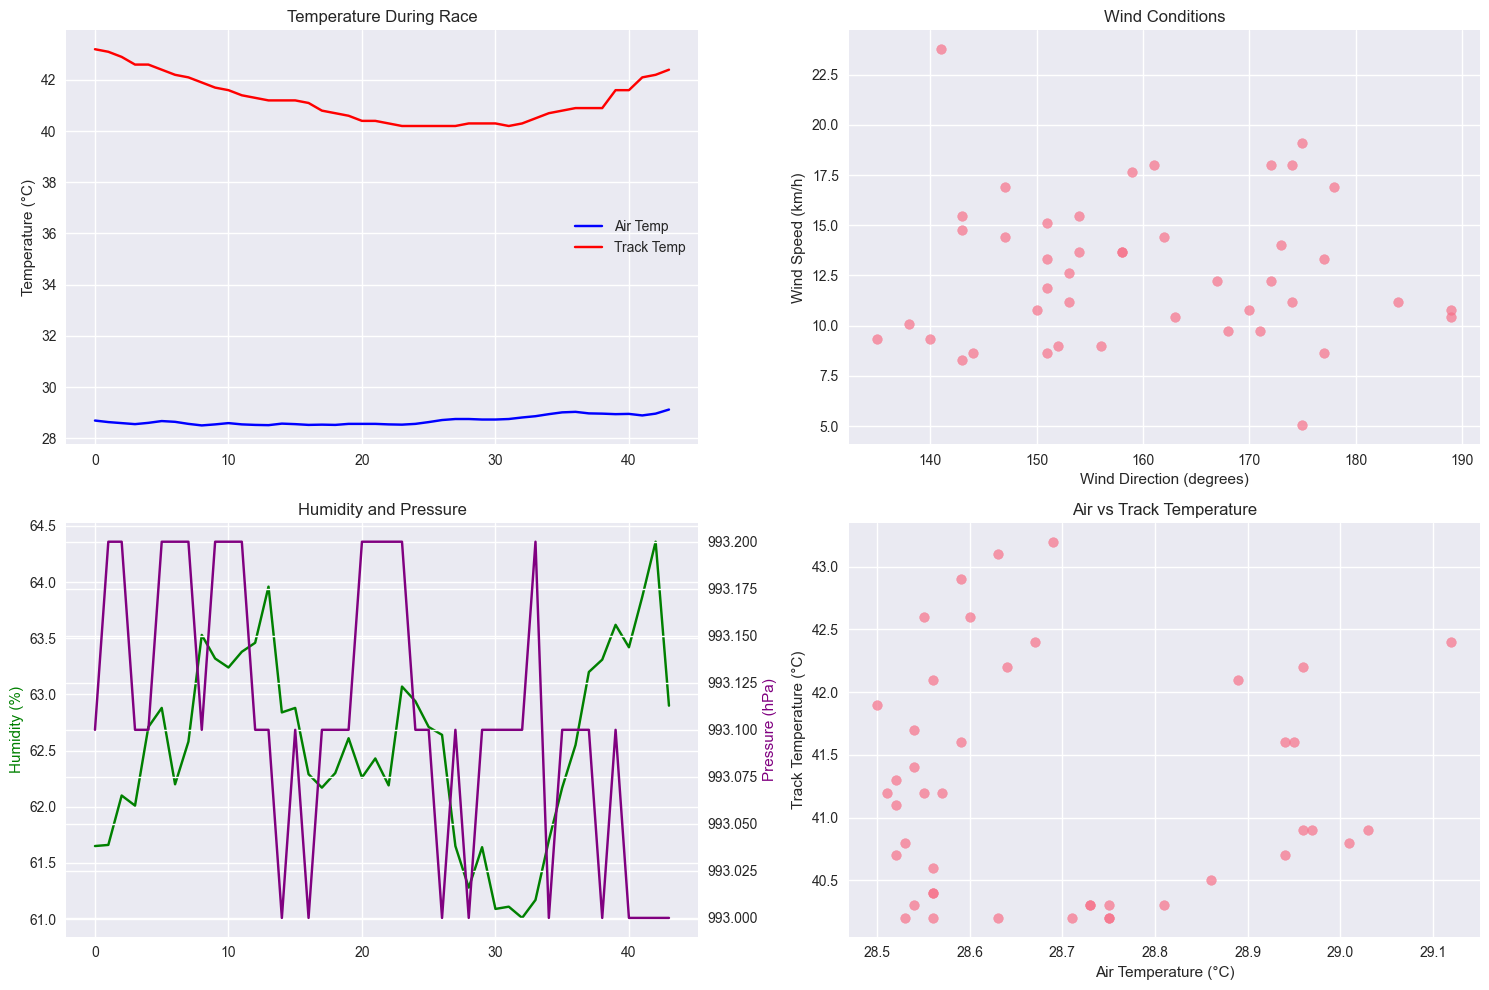

In [15]:
# Weather trends during race
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Temperature trends
axes[0,0].plot(weather['AIR_TEMP'], label='Air Temp', color='blue')
axes[0,0].plot(weather['TRACK_TEMP'], label='Track Temp', color='red')
axes[0,0].set_title('Temperature During Race')
axes[0,0].set_ylabel('Temperature (°C)')
axes[0,0].legend()

# Wind conditions
axes[0,1].scatter(weather['WIND_DIRECTION'], weather['WIND_SPEED'], alpha=0.7)
axes[0,1].set_xlabel('Wind Direction (degrees)')
axes[0,1].set_ylabel('Wind Speed (km/h)')
axes[0,1].set_title('Wind Conditions')

# Humidity and pressure
ax2 = axes[1,0].twinx()
axes[1,0].plot(weather['HUMIDITY'], color='green', label='Humidity')
ax2.plot(weather['PRESSURE'], color='purple', label='Pressure')
axes[1,0].set_ylabel('Humidity (%)', color='green')
ax2.set_ylabel('Pressure (hPa)', color='purple')
axes[1,0].set_title('Humidity and Pressure')

# Track temp vs air temp correlation
axes[1,1].scatter(weather['AIR_TEMP'], weather['TRACK_TEMP'], alpha=0.7)
axes[1,1].set_xlabel('Air Temperature (°C)')
axes[1,1].set_ylabel('Track Temperature (°C)')
axes[1,1].set_title('Air vs Track Temperature')

plt.tight_layout()
plt.show()

## 4. Driver Performance Comparison

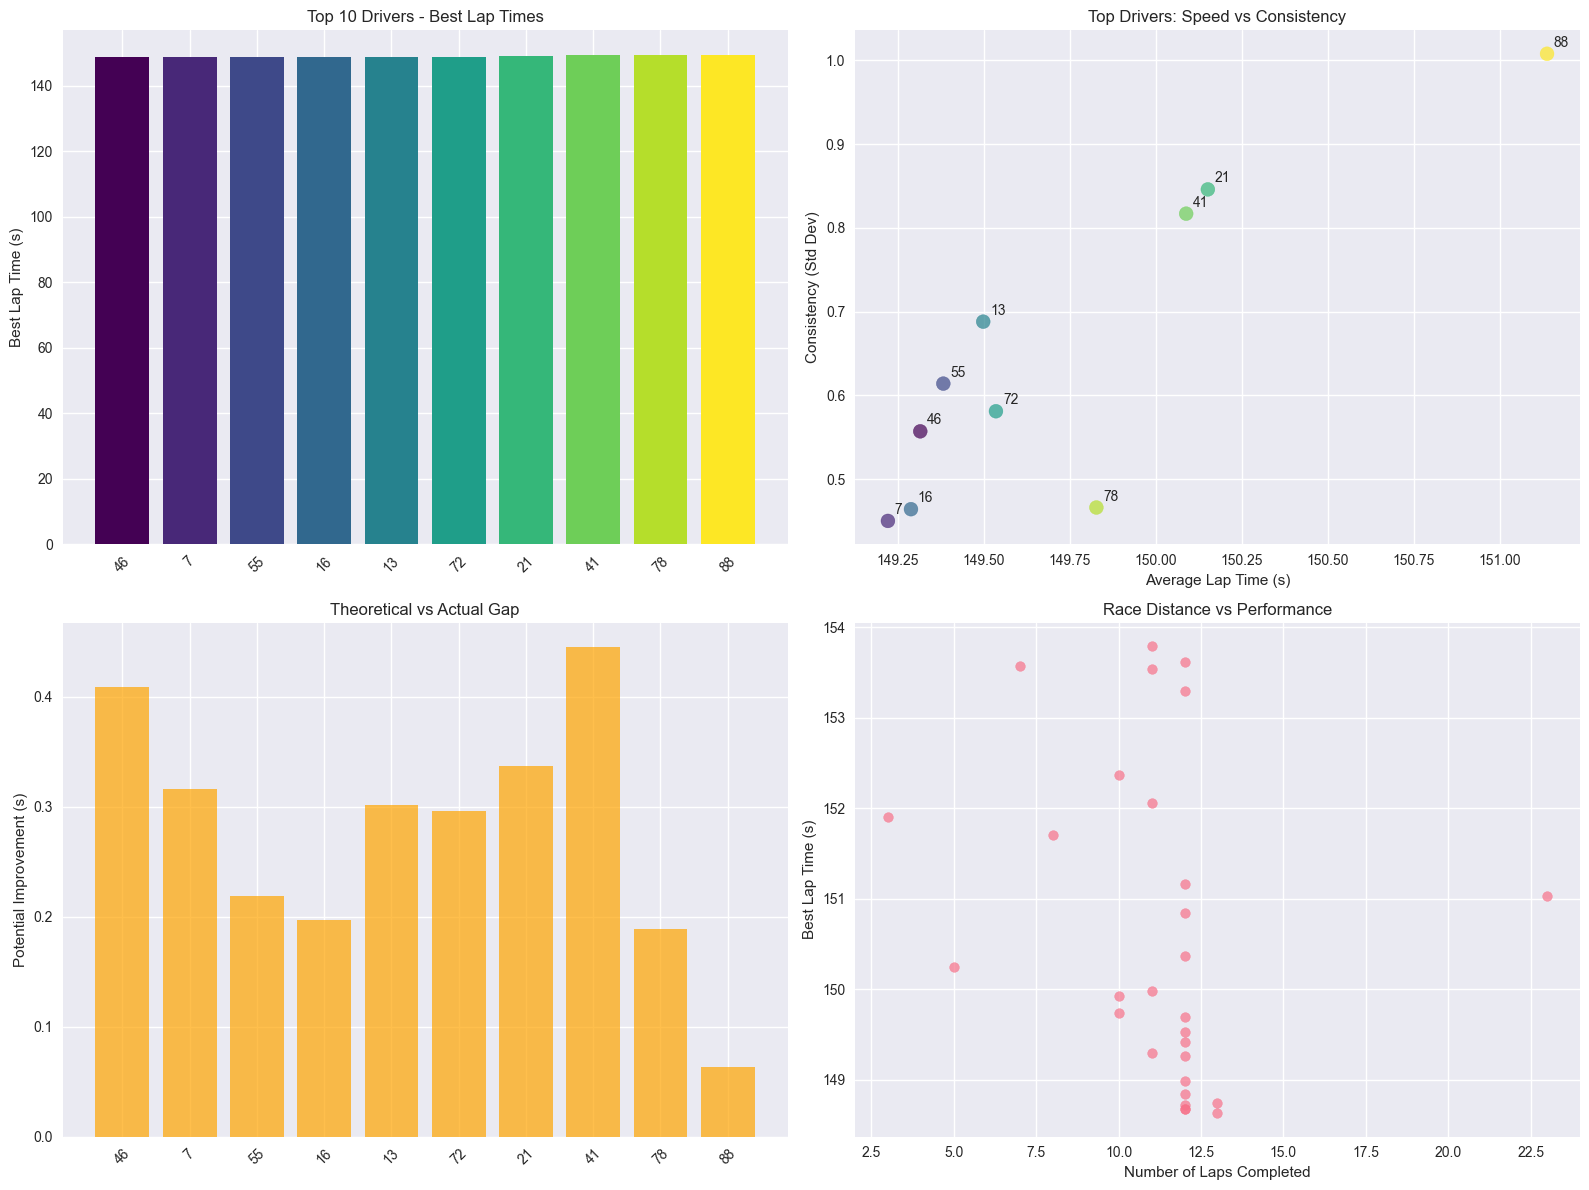

In [16]:
# Top 10 drivers by best lap
top_drivers = driver_stats.nsmallest(10, 'BestLap(s)')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Best lap comparison
bars = axes[0,0].bar(range(len(top_drivers)), top_drivers['BestLap(s)'], 
                     color=plt.cm.viridis(np.linspace(0, 1, len(top_drivers))))
axes[0,0].set_xticks(range(len(top_drivers)))
axes[0,0].set_xticklabels(top_drivers['DriverNumber'], rotation=45)
axes[0,0].set_ylabel('Best Lap Time (s)')
axes[0,0].set_title('Top 10 Drivers - Best Lap Times')

# Sector performance radar chart data prep
sectors = ['S1Best', 'S2Best', 'S3Best']
top_3 = top_drivers.head(3)

# Consistency vs speed
axes[0,1].scatter(top_drivers['AvgLap(s)'], top_drivers['StdDev(s)'], 
                  s=100, alpha=0.7, c=range(len(top_drivers)), cmap='viridis')
for i, driver in enumerate(top_drivers['DriverNumber']):
    axes[0,1].annotate(str(driver), 
                       (top_drivers.iloc[i]['AvgLap(s)'], top_drivers.iloc[i]['StdDev(s)']),
                       xytext=(5, 5), textcoords='offset points')
axes[0,1].set_xlabel('Average Lap Time (s)')
axes[0,1].set_ylabel('Consistency (Std Dev)')
axes[0,1].set_title('Top Drivers: Speed vs Consistency')

# Theoretical potential
potential_gain = top_drivers['BestLap(s)'] - top_drivers['TheoreticalBest(s)']
axes[1,0].bar(range(len(top_drivers)), potential_gain, 
              color='orange', alpha=0.7)
axes[1,0].set_xticks(range(len(top_drivers)))
axes[1,0].set_xticklabels(top_drivers['DriverNumber'], rotation=45)
axes[1,0].set_ylabel('Potential Improvement (s)')
axes[1,0].set_title('Theoretical vs Actual Gap')

# Lap count vs performance
axes[1,1].scatter(driver_stats['Laps'], driver_stats['BestLap(s)'], alpha=0.7)
axes[1,1].set_xlabel('Number of Laps Completed')
axes[1,1].set_ylabel('Best Lap Time (s)')
axes[1,1].set_title('Race Distance vs Performance')

plt.tight_layout()
plt.show()

## 5. Interactive Plotly Visualizations

In [17]:
# Interactive lap time progression
fig = go.Figure()

# Add traces for top 5 drivers
top_5_drivers = driver_stats.nsmallest(5, 'BestLap(s)')['DriverNumber'].tolist()

for driver in top_5_drivers:
    driver_laps = lap_data[lap_data['NUMBER'] == driver].sort_values('LAP_NUMBER')
    fig.add_trace(go.Scatter(
        x=driver_laps['LAP_NUMBER'],
        y=driver_laps['LAP_TIME_SEC'],
        mode='lines+markers',
        name=f'Driver {driver}',
        hovertemplate='Lap: %{x}<br>Time: %{y:.3f}s<extra></extra>'
    ))

fig.update_layout(
    title='Lap Time Progression - Top 5 Drivers',
    xaxis_title='Lap Number',
    yaxis_title='Lap Time (seconds)',
    hovermode='x unified'
)

fig.show()

In [18]:
# 3D Performance Analysis
fig = px.scatter_3d(
    driver_stats, 
    x='BestLap(s)', 
    y='AvgLap(s)', 
    z='StdDev(s)',
    color='Laps',
    size='TheoreticalBest(s)',
    hover_data=['DriverNumber'],
    title='3D Driver Performance Analysis'
)

fig.update_layout(
    scene=dict(
        xaxis_title='Best Lap Time (s)',
        yaxis_title='Average Lap Time (s)',
        zaxis_title='Consistency (Std Dev)'
    )
)

fig.show()

## 6. Sector Analysis Deep Dive

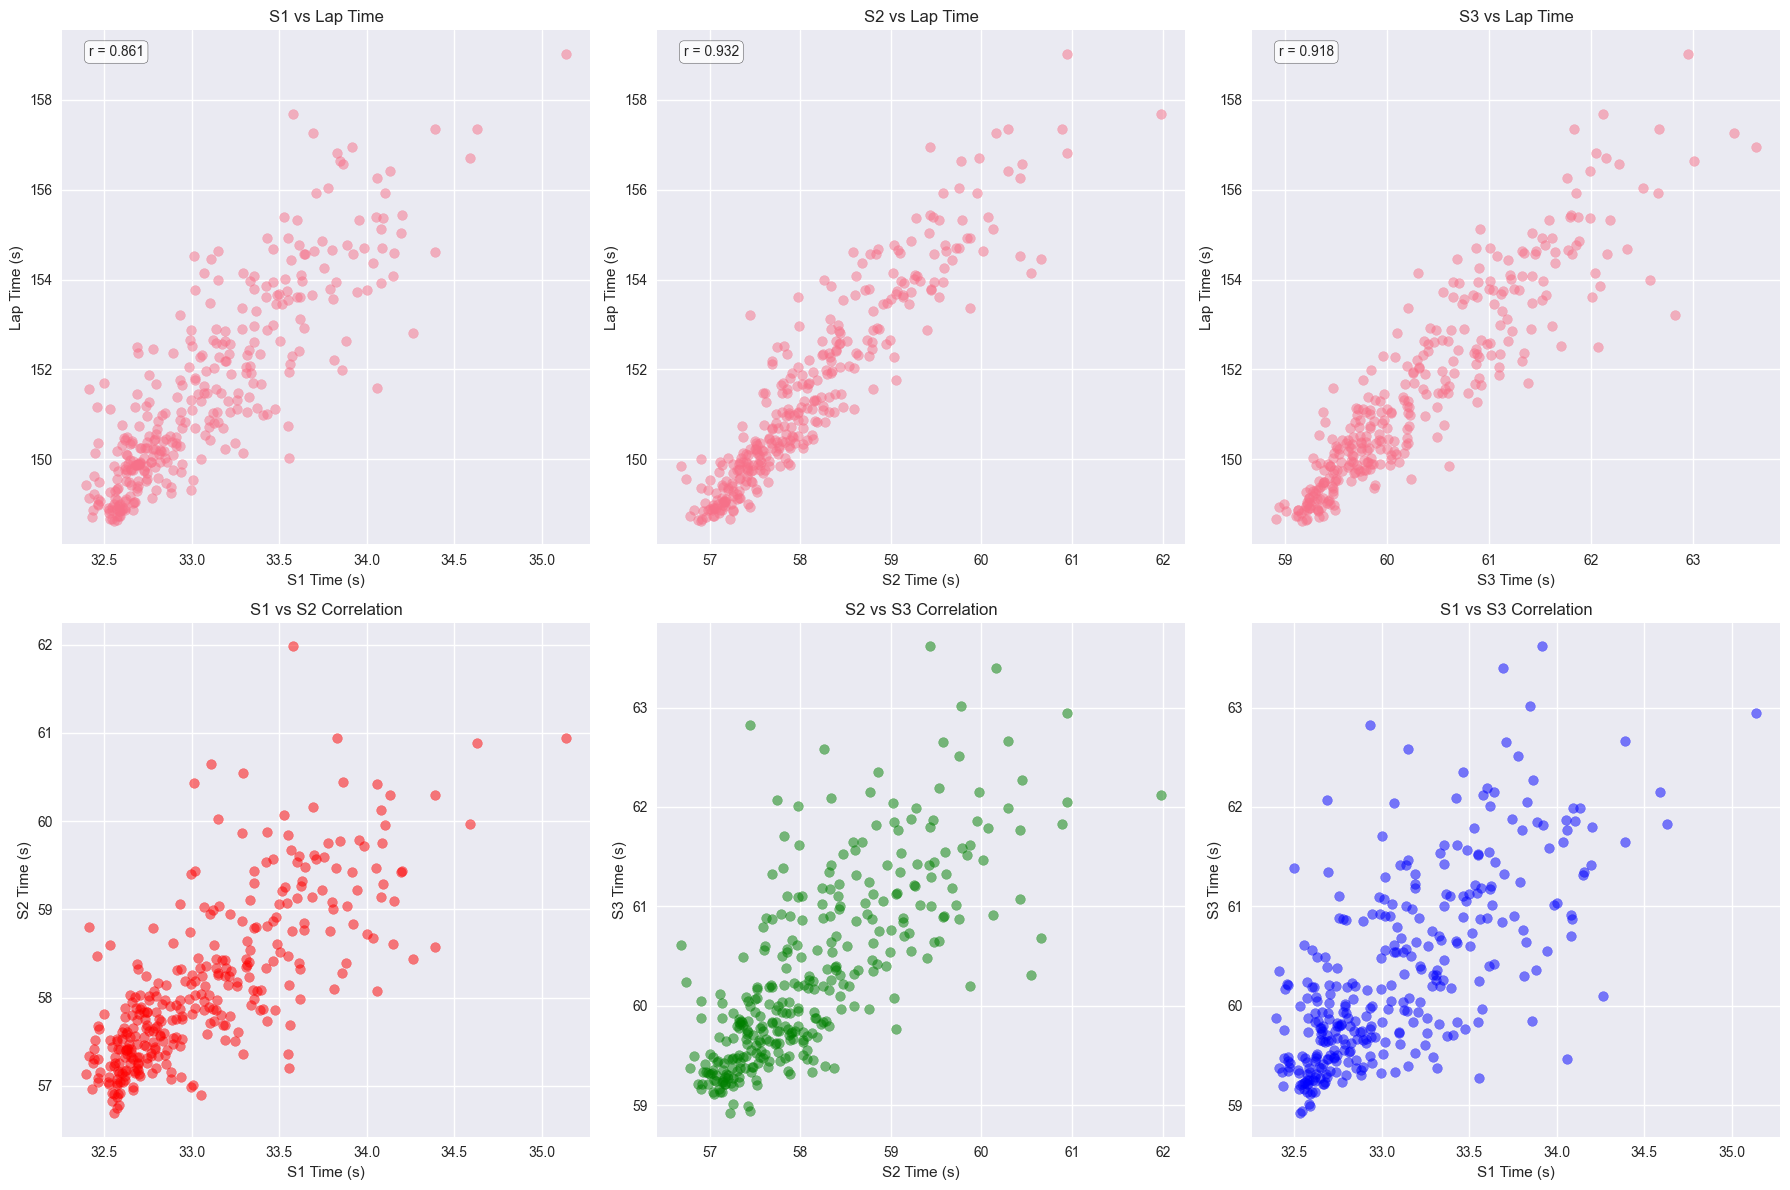

In [19]:
# Sector correlation analysis
sector_data = lap_data[['S1_SEC', 'S2_SEC', 'S3_SEC', 'LAP_TIME_SEC']].dropna()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Sector vs lap time correlations
for i, sector in enumerate(['S1_SEC', 'S2_SEC', 'S3_SEC']):
    axes[0, i].scatter(sector_data[sector], sector_data['LAP_TIME_SEC'], alpha=0.5)
    axes[0, i].set_xlabel(f'{sector.replace("_SEC", "")} Time (s)')
    axes[0, i].set_ylabel('Lap Time (s)')
    axes[0, i].set_title(f'{sector.replace("_SEC", "")} vs Lap Time')
    
    # Add correlation coefficient
    corr = sector_data[sector].corr(sector_data['LAP_TIME_SEC'])
    axes[0, i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0, i].transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Sector interdependencies
axes[1, 0].scatter(sector_data['S1_SEC'], sector_data['S2_SEC'], alpha=0.5, color='red')
axes[1, 0].set_xlabel('S1 Time (s)')
axes[1, 0].set_ylabel('S2 Time (s)')
axes[1, 0].set_title('S1 vs S2 Correlation')

axes[1, 1].scatter(sector_data['S2_SEC'], sector_data['S3_SEC'], alpha=0.5, color='green')
axes[1, 1].set_xlabel('S2 Time (s)')
axes[1, 1].set_ylabel('S3 Time (s)')
axes[1, 1].set_title('S2 vs S3 Correlation')

axes[1, 2].scatter(sector_data['S1_SEC'], sector_data['S3_SEC'], alpha=0.5, color='blue')
axes[1, 2].set_xlabel('S1 Time (s)')
axes[1, 2].set_ylabel('S3 Time (s)')
axes[1, 2].set_title('S1 vs S3 Correlation')

plt.tight_layout()
plt.show()

## 7. Advanced Statistical Analysis

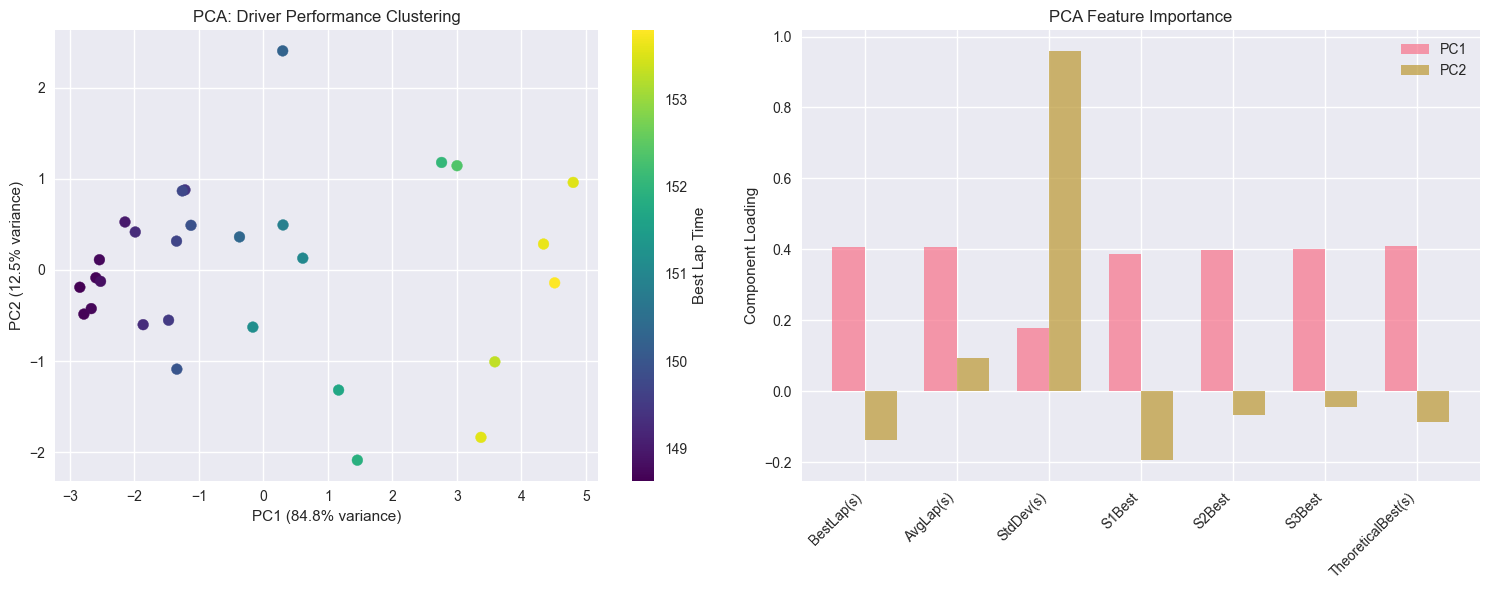

Total variance explained: 97.3%


In [20]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Principal Component Analysis
features = ['BestLap(s)', 'AvgLap(s)', 'StdDev(s)', 'S1Best', 'S2Best', 'S3Best', 'TheoreticalBest(s)']
X = driver_stats[features].fillna(driver_stats[features].mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# PCA scatter plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=driver_stats['BestLap(s)'], cmap='viridis', s=60)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('PCA: Driver Performance Clustering')
plt.colorbar(scatter, ax=axes[0], label='Best Lap Time')

# Feature importance in PCA
feature_importance = pd.DataFrame({
    'Feature': features,
    'PC1': pca.components_[0],
    'PC2': pca.components_[1]
})

x_pos = np.arange(len(features))
width = 0.35
axes[1].bar(x_pos - width/2, feature_importance['PC1'], width, label='PC1', alpha=0.7)
axes[1].bar(x_pos + width/2, feature_importance['PC2'], width, label='PC2', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(features, rotation=45, ha='right')
axes[1].set_ylabel('Component Loading')
axes[1].set_title('PCA Feature Importance')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## 8. Performance Efficiency Analysis

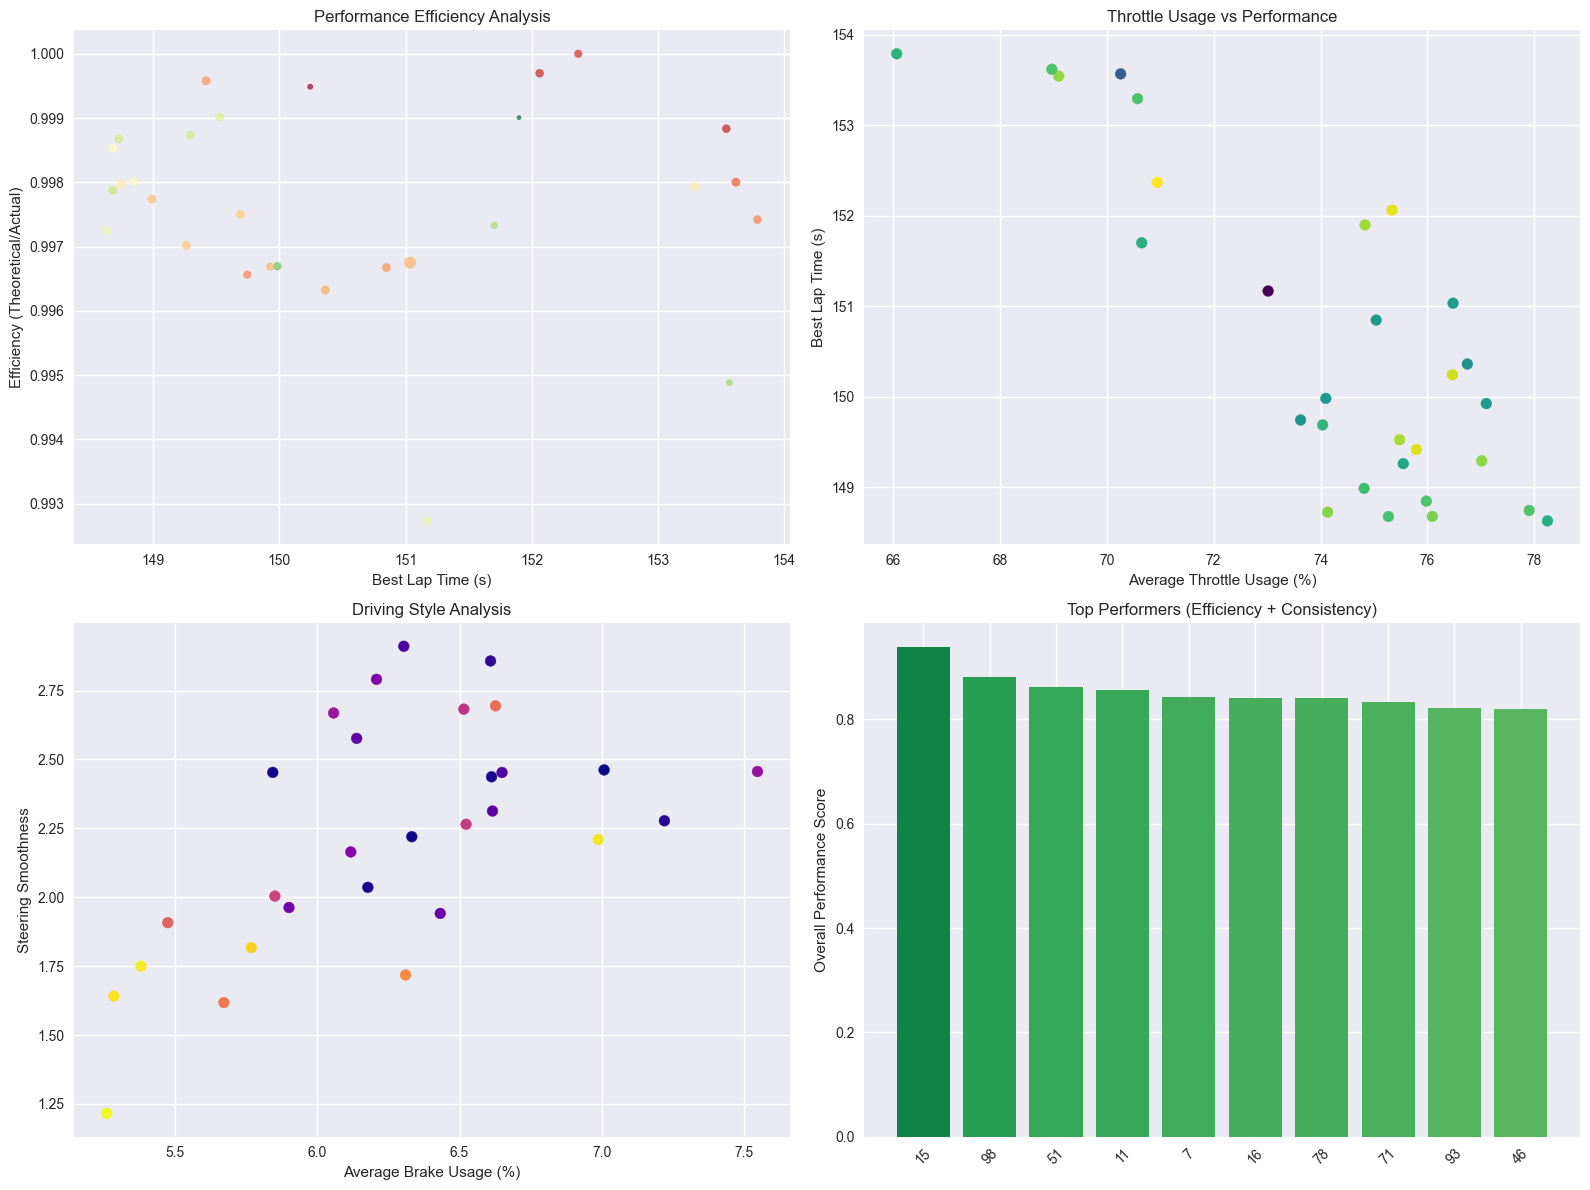


Top 5 Overall Performers:
    DriverNumber  BestLap(s)  efficiency  consistency_score  overall_score
7             15     151.899    0.999006           0.877193       0.938099
27            98     149.983    0.996693           0.767460       0.882076
15            51     153.568    0.994882           0.729927       0.862404
4             11     151.702    0.997330           0.714796       0.856063
2              7     148.678    0.997875           0.689655       0.843765


In [21]:
# Calculate efficiency metrics
driver_stats['efficiency'] = driver_stats['TheoreticalBest(s)'] / driver_stats['BestLap(s)']
driver_stats['consistency_score'] = 1 / (1 + driver_stats['StdDev(s)'])
driver_stats['overall_score'] = (driver_stats['efficiency'] + driver_stats['consistency_score']) / 2

# Merge with telemetry averages
telemetry_avg = telemetry_summary.groupby('NUMBER').agg({
    'mean_throttle': 'mean',
    'mean_brake': 'mean', 
    'steering_smoothness': 'mean'
}).reset_index()

driver_analysis = driver_stats.merge(telemetry_avg, left_on='DriverNumber', right_on='NUMBER', how='left')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Efficiency vs Performance
axes[0,0].scatter(driver_analysis['BestLap(s)'], driver_analysis['efficiency'], 
                  s=driver_analysis['Laps']*3, alpha=0.7, c=driver_analysis['overall_score'], cmap='RdYlGn')
axes[0,0].set_xlabel('Best Lap Time (s)')
axes[0,0].set_ylabel('Efficiency (Theoretical/Actual)')
axes[0,0].set_title('Performance Efficiency Analysis')

# Throttle efficiency
axes[0,1].scatter(driver_analysis['mean_throttle'], driver_analysis['BestLap(s)'], 
                  c=driver_analysis['efficiency'], cmap='viridis', s=60)
axes[0,1].set_xlabel('Average Throttle Usage (%)')
axes[0,1].set_ylabel('Best Lap Time (s)')
axes[0,1].set_title('Throttle Usage vs Performance')

# Brake vs Steering correlation
axes[1,0].scatter(driver_analysis['mean_brake'], driver_analysis['steering_smoothness'], 
                  c=driver_analysis['BestLap(s)'], cmap='plasma', s=60)
axes[1,0].set_xlabel('Average Brake Usage (%)')
axes[1,0].set_ylabel('Steering Smoothness')
axes[1,0].set_title('Driving Style Analysis')

# Overall performance ranking
top_performers = driver_analysis.nlargest(10, 'overall_score')
bars = axes[1,1].bar(range(len(top_performers)), top_performers['overall_score'], 
                     color=plt.cm.RdYlGn(top_performers['overall_score']))
axes[1,1].set_xticks(range(len(top_performers)))
axes[1,1].set_xticklabels(top_performers['DriverNumber'], rotation=45)
axes[1,1].set_ylabel('Overall Performance Score')
axes[1,1].set_title('Top Performers (Efficiency + Consistency)')

plt.tight_layout()
plt.show()

# Print top performers
print("\nTop 5 Overall Performers:")
print(top_performers[['DriverNumber', 'BestLap(s)', 'efficiency', 'consistency_score', 'overall_score']].head())

## 9. Race Strategy Analysis

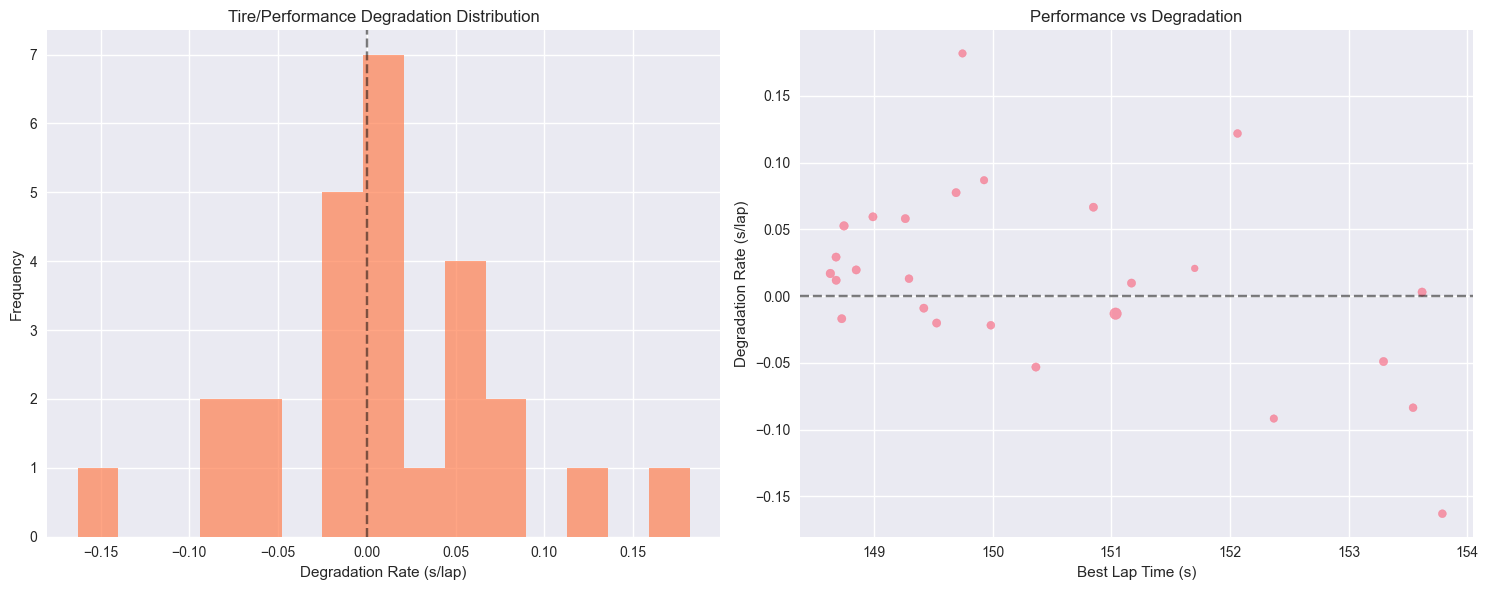


Drivers with best tire management (lowest degradation):
    driver  BestLap(s)  degradation_rate  Laps
3        8     153.790         -0.162913    11
19      80     152.369         -0.091652    10
8       18     153.543         -0.083502    11
6       14     150.363         -0.053070    12
20      86     153.294         -0.048924    12


In [22]:
# Lap time degradation analysis
def analyze_degradation(driver_num, min_laps=8):
    driver_laps = lap_data[lap_data['NUMBER'] == driver_num].sort_values('LAP_NUMBER')
    if len(driver_laps) < min_laps:
        return None
    
    # Linear regression for degradation
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        driver_laps['LAP_NUMBER'], driver_laps['LAP_TIME_SEC']
    )
    
    return {
        'driver': driver_num,
        'degradation_rate': slope,
        'correlation': r_value,
        'p_value': p_value
    }

# Analyze all drivers
degradation_data = []
for driver in driver_stats['DriverNumber']:
    result = analyze_degradation(driver)
    if result:
        degradation_data.append(result)

degradation_df = pd.DataFrame(degradation_data)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Degradation rate distribution
axes[0].hist(degradation_df['degradation_rate'], bins=15, alpha=0.7, color='coral')
axes[0].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Degradation Rate (s/lap)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tire/Performance Degradation Distribution')

# Degradation vs best lap
merged_deg = degradation_df.merge(driver_stats, left_on='driver', right_on='DriverNumber')
axes[1].scatter(merged_deg['BestLap(s)'], merged_deg['degradation_rate'], 
                s=merged_deg['Laps']*3, alpha=0.7)
axes[1].set_xlabel('Best Lap Time (s)')
axes[1].set_ylabel('Degradation Rate (s/lap)')
axes[1].set_title('Performance vs Degradation')
axes[1].axhline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nDrivers with best tire management (lowest degradation):")
print(merged_deg.nsmallest(5, 'degradation_rate')[['driver', 'BestLap(s)', 'degradation_rate', 'Laps']])

## 10. Summary Dashboard

In [23]:
# Create comprehensive summary
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=('Lap Time Distribution', 'Performance vs Consistency', 
                   'Sector Performance', 'Weather Conditions',
                   'Telemetry Correlations', 'Top Performers'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": True}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Lap time distribution
fig.add_trace(
    go.Histogram(x=driver_stats['BestLap(s)'], name='Best Lap Times', nbinsx=15),
    row=1, col=1
)

# Performance vs consistency
fig.add_trace(
    go.Scatter(x=driver_stats['AvgLap(s)'], y=driver_stats['StdDev(s)'],
               mode='markers', name='Drivers',
               marker=dict(size=8, color=driver_stats['BestLap(s)'], 
                          colorscale='viridis', showscale=True)),
    row=1, col=2
)

# Sector performance
for i, sector in enumerate(['S1Best', 'S2Best', 'S3Best']):
    fig.add_trace(
        go.Box(y=driver_stats[sector], name=f'Sector {i+1}'),
        row=2, col=1
    )

# Weather conditions
fig.add_trace(
    go.Scatter(x=list(range(len(weather))), y=weather['AIR_TEMP'], 
               name='Air Temp', line=dict(color='blue')),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=list(range(len(weather))), y=weather['TRACK_TEMP'], 
               name='Track Temp', line=dict(color='red')),
    row=2, col=2, secondary_y=True
)

# Telemetry correlation (if data available)
if not telemetry_with_times.empty:
    fig.add_trace(
        go.Scatter(x=telemetry_with_times['mean_throttle'], 
                   y=telemetry_with_times['LAP_TIME_SEC'],
                   mode='markers', name='Throttle vs Lap Time',
                   marker=dict(size=4, opacity=0.6)),
        row=3, col=1
    )

# Top performers
top_5 = driver_stats.nsmallest(5, 'BestLap(s)')
fig.add_trace(
    go.Bar(x=top_5['DriverNumber'].astype(str), y=top_5['BestLap(s)'],
           name='Top 5 Best Laps'),
    row=3, col=2
)

fig.update_layout(height=1200, showlegend=False, 
                  title_text="Toyota GR Racing Analysis Dashboard")
fig.show()

# Print key insights
print("\n=== KEY INSIGHTS ===")
print(f"Fastest lap: {driver_stats['BestLap(s)'].min():.3f}s by Driver {driver_stats.loc[driver_stats['BestLap(s)'].idxmin(), 'DriverNumber']}")
print(f"Most consistent: Driver {driver_stats.loc[driver_stats['StdDev(s)'].idxmin(), 'DriverNumber']} (σ = {driver_stats['StdDev(s)'].min():.3f}s)")
print(f"Best theoretical potential: {driver_stats['TheoreticalBest(s)'].min():.3f}s")
print(f"Temperature range: {weather['TRACK_TEMP'].min():.1f}°C - {weather['TRACK_TEMP'].max():.1f}°C")


=== KEY INSIGHTS ===
Fastest lap: 148.630s by Driver 46
Most consistent: Driver 15 (σ = 0.140s)
Best theoretical potential: 148.221s
Temperature range: 40.2°C - 43.2°C
